In [63]:
import os, sys
currentdir = os.path.dirname(os.path.realpath('testing_pipeline.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from importlib import reload  
import numpy as np
from skimage.io import imread, imshow
import random
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Concatenate, concatenate, Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda

from src import pipeline
pipeline = reload(pipeline)

In [64]:
# very complicated way to plot
# https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally
from IPython.display import HTML
import io
import base64

class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))


In [65]:
# Custom Keras layer

class SpaceToDepth(tf.keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'block_size': self.block_size,
        })
        return config

# Unet Mask

In [72]:
path = '../data/stacking/slice_test'
unet_model = '../data/weights/model_unet_checkpoint.h5'
yolo2_model = '../data/weights/yolo2_model.h5'
input_img = '../data/stacking/SCAN_2021-03-05_15-50-16/2021-03-05_15-50-16_0_0_5578.jpeg'
output_dir = '../data/stacking/slice_test'
slice_height = 1280
slice_width = 1280

In [73]:
pipeline.slice_img(input_img, output_dir, resize_factor = 1,
                  slice_height = slice_height, slice_width = slice_width,
                  zero_frac_tresh = 0.8, overlap = 0, pad = 0, verbose = True)

Directory  ../data/stacking/slice_test  already exists
dx 1280
dy 1280
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_0_1280_1280_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_1280_1280_1280_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_1184_0_1280_1280_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_1184_1280_1280_1280_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_1184_2000_1280_1280_0.png
Num slices: 6 Num non-null slices: 0 sliceHeight 1280 sliceWidth 1280


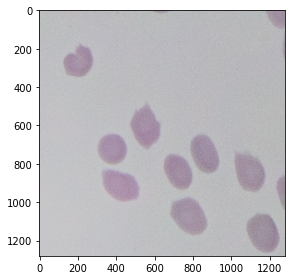

In [74]:
imgs, sizes_imgs  = pipeline.get_imgs(path, img_height = slice_height, img_width = slice_width, img_channels = 3)
imshow(imgs[0])

In [75]:
imgs[0].shape

(1280, 1280, 3)

In [76]:
img_height = 256
img_width = 256
img_channels = 3
imgs_red = np.zeros((len(imgs), img_height, img_width, img_channels), dtype=np.uint8)
sizes_imgs_red = []
for idx, img in enumerate(imgs):
    img_red = cv2.resize(img, (img_height, img_width))
    #Append image to numpy array
    imgs_red[idx] = img_red
    #Append image shape to numpy array
    sizes_imgs_red.append([img_red.shape[0], img_red.shape[1]])

In [77]:
sizes_imgs_red

[[256, 256], [256, 256], [256, 256], [256, 256], [256, 256], [256, 256]]

In [78]:
pred_masks_t = pipeline.unet_predict(unet_model, imgs_red, sizes_imgs_red)

1/1 [==============================] - 1s 1s/step



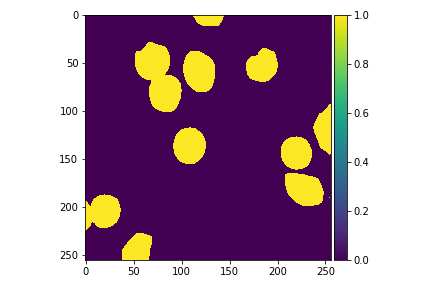
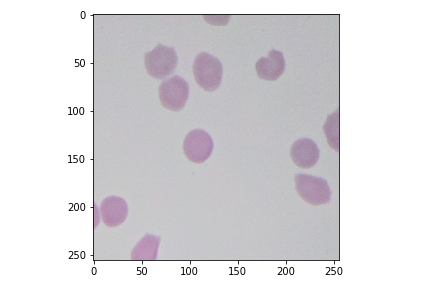
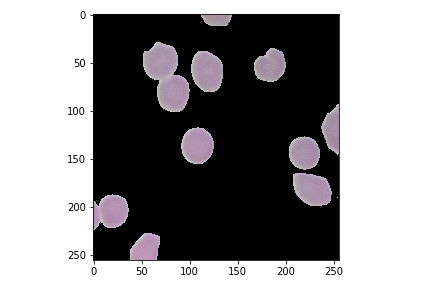

In [80]:
#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

# Perform check on test set
ix = random.randint(0, len(pred_masks_t)-1)
oPlot.add_plot(imshow(np.squeeze(pred_masks_t[ix])))
plt.close() 
oPlot.add_plot(imshow(imgs_red[ix]))
plt.close() 
image_overlayed = np.where(np.squeeze(pred_masks_t[ix])[...,None], imgs_red[ix], 0)
oPlot.add_plot(imshow(image_overlayed)) # pass it to the FlowLayout to save as an image
plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()


In [81]:
num_labels, labels = cv2.connectedComponents(np.squeeze(pred_masks_t[ix]))

In [82]:
num_labels

12


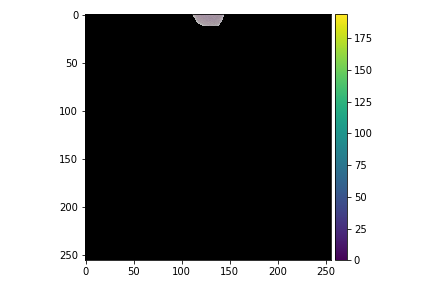
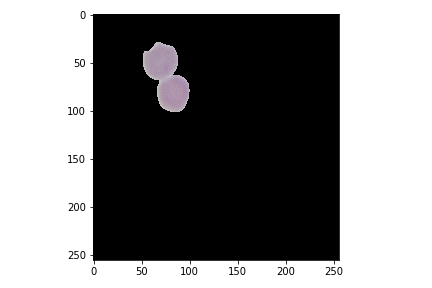
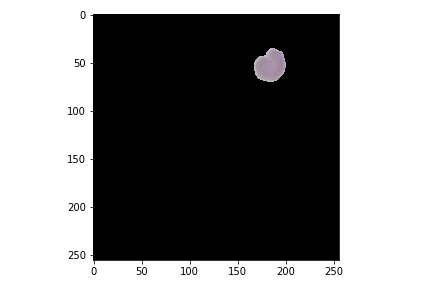
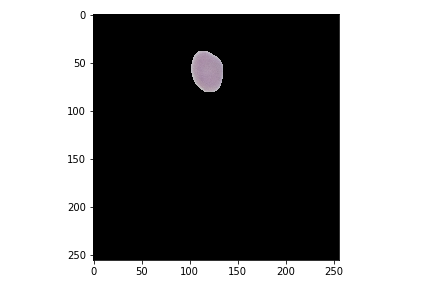
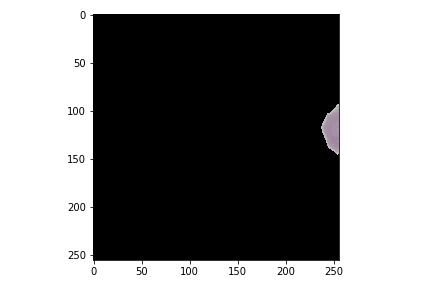
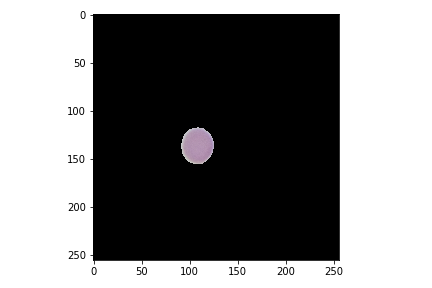
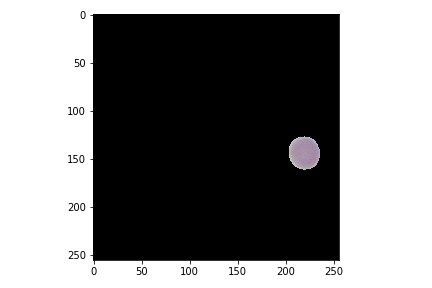
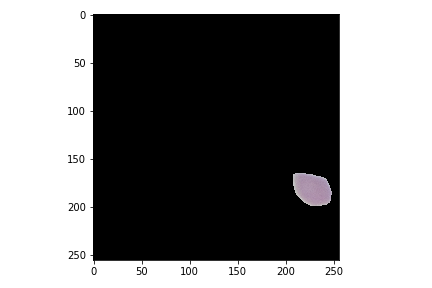
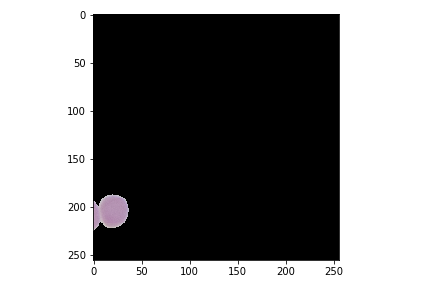
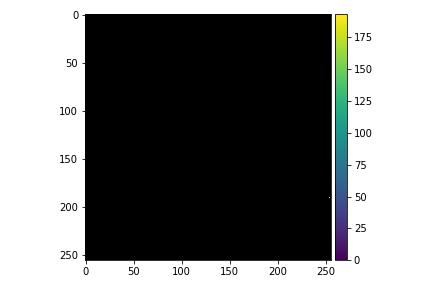
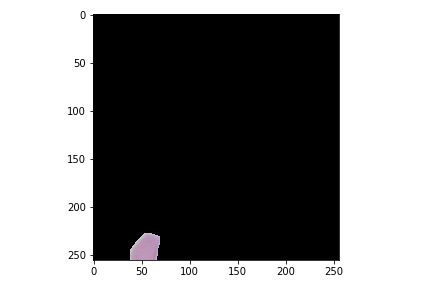

In [84]:
#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

for label in range(1,num_labels):
    component = np.where(np.where(labels == label, 1, 0)[...,None], imgs_red[ix], 0)
    oPlot.add_plot(imshow(component)) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()

In [85]:
yolo_model = load_model(yolo2_model, custom_objects={'SpaceToDepth': SpaceToDepth})

<Figure size 144x144 with 0 Axes>

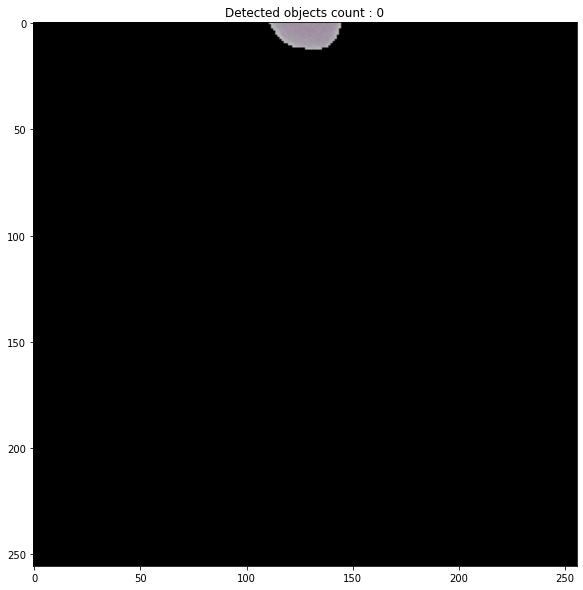

<Figure size 144x144 with 0 Axes>

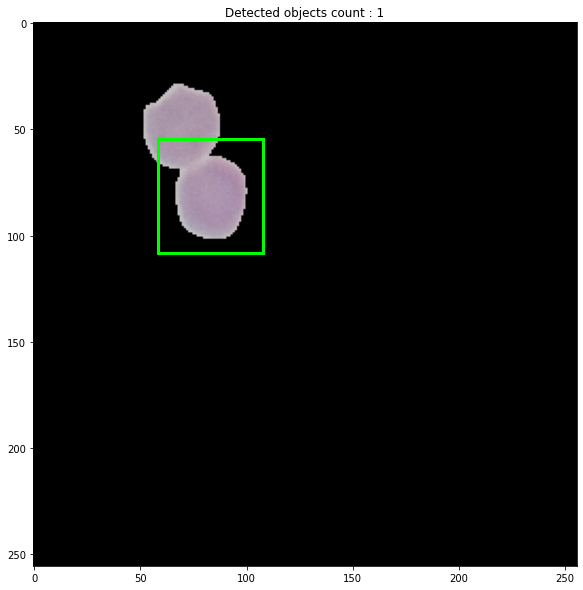

<Figure size 144x144 with 0 Axes>

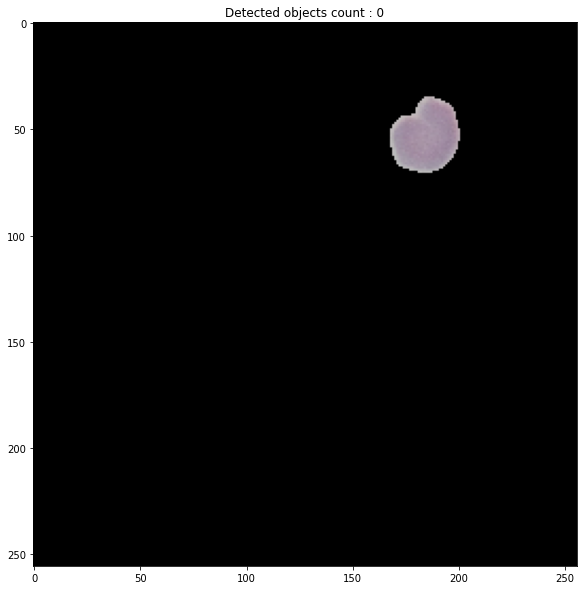

<Figure size 144x144 with 0 Axes>

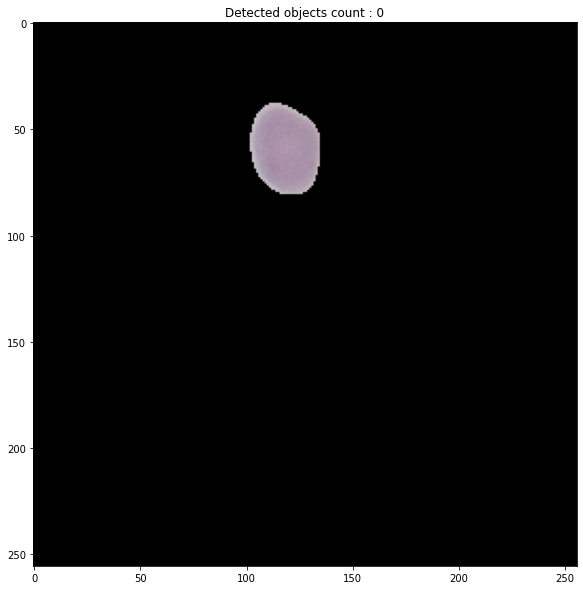

<Figure size 144x144 with 0 Axes>

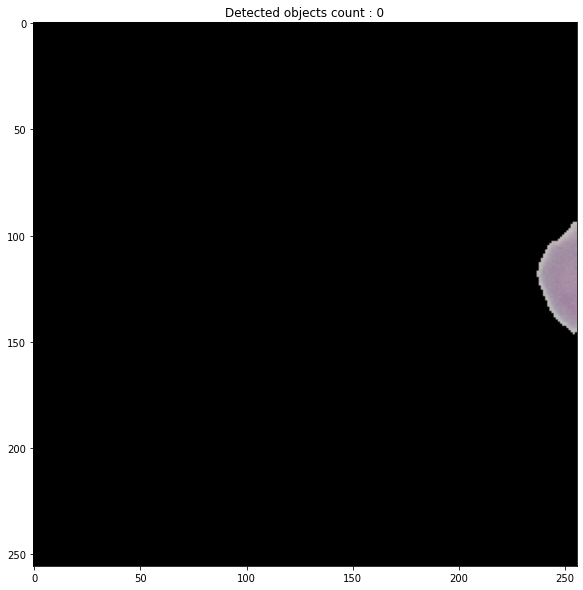

<Figure size 144x144 with 0 Axes>

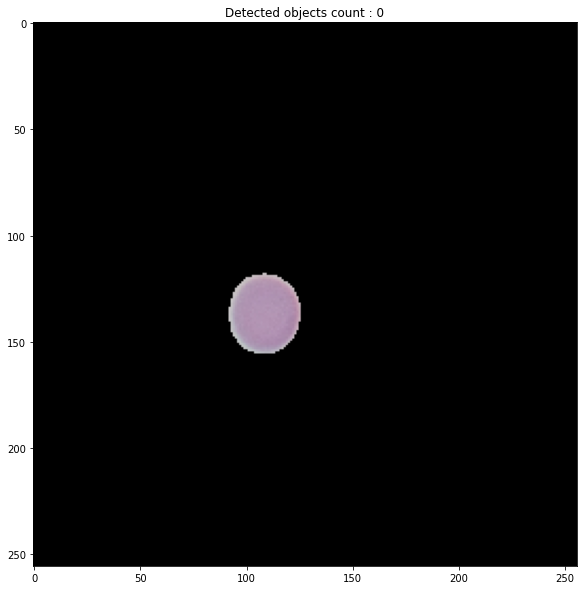

<Figure size 144x144 with 0 Axes>

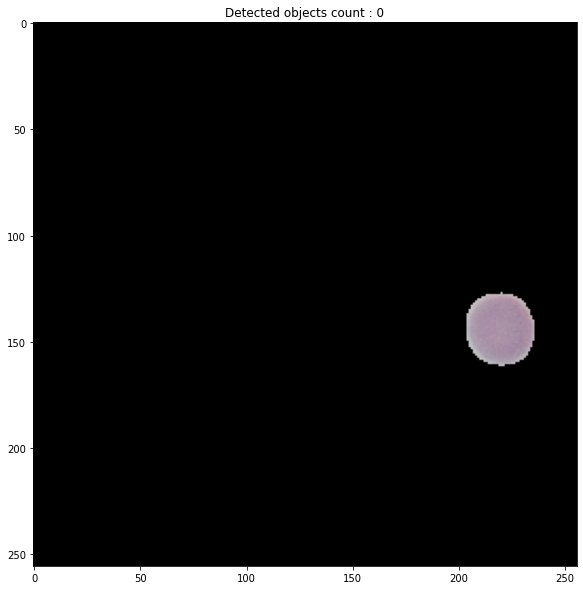

<Figure size 144x144 with 0 Axes>

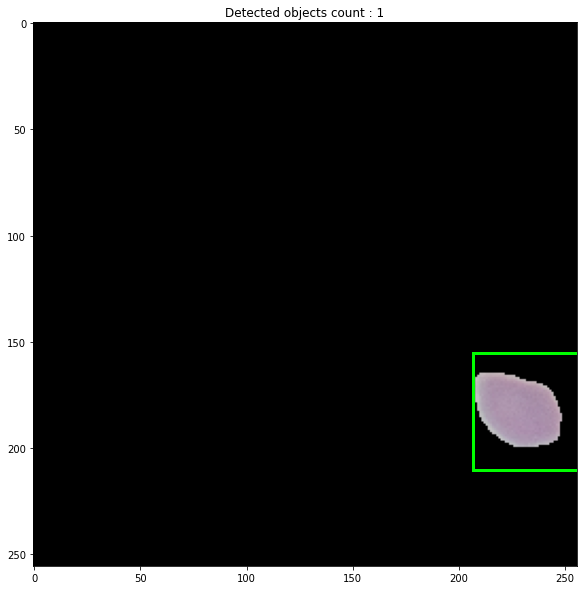

<Figure size 144x144 with 0 Axes>

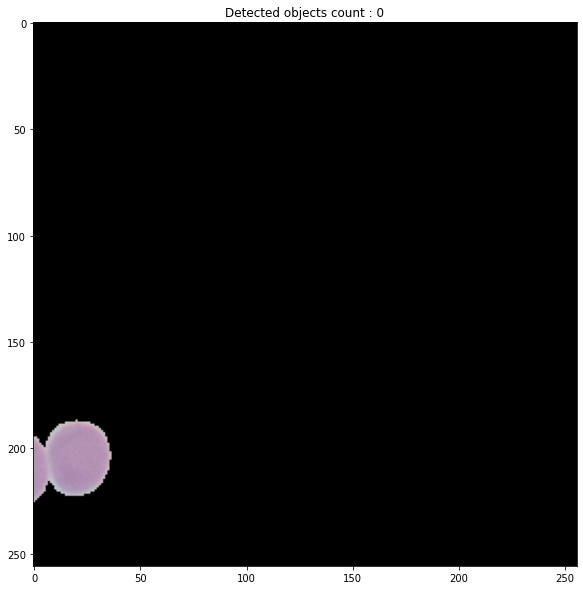

<Figure size 144x144 with 0 Axes>

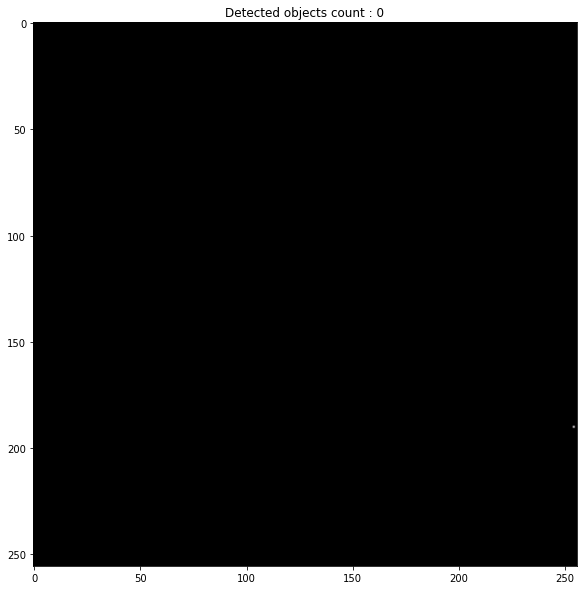

<Figure size 144x144 with 0 Axes>

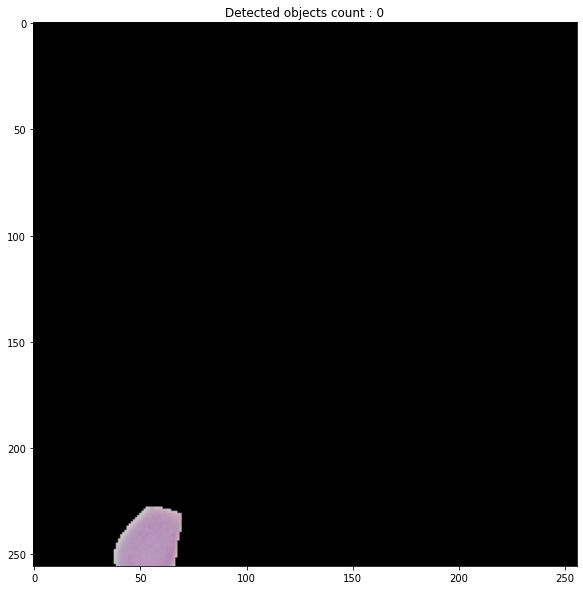

In [87]:
score_threshold  = 0.5
iou_threshold    = 0.45
for label in range(1,num_labels):
    component = np.where(np.where(labels == label, 1, 0)[...,None], imgs_red[ix], 0)
    pipeline.display_yolo(component, yolo_model, score_threshold, iou_threshold, plot = True)

<Figure size 144x144 with 0 Axes>

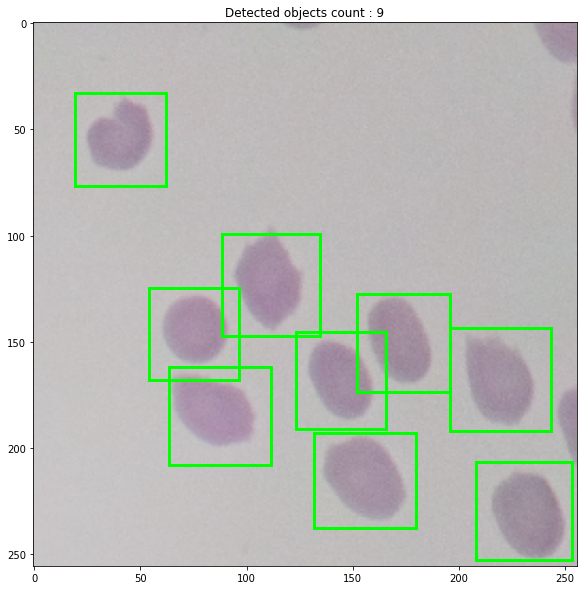

<Figure size 144x144 with 0 Axes>

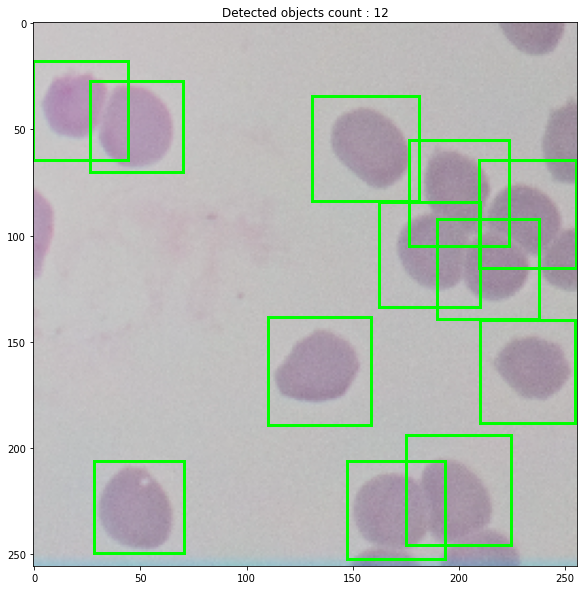

<Figure size 144x144 with 0 Axes>

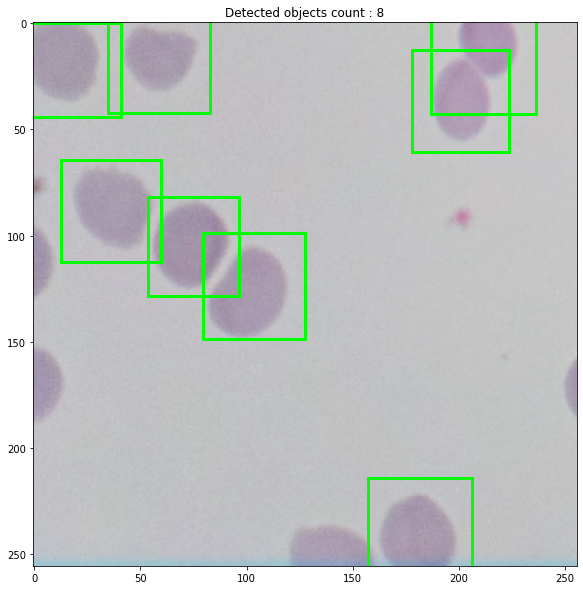

<Figure size 144x144 with 0 Axes>

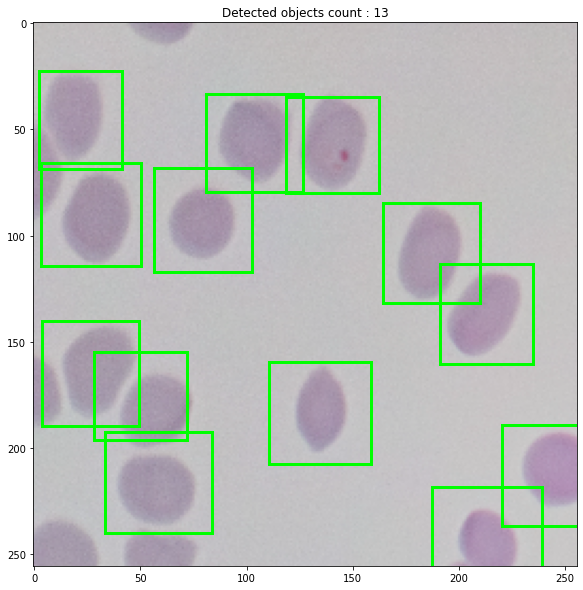

<Figure size 144x144 with 0 Axes>

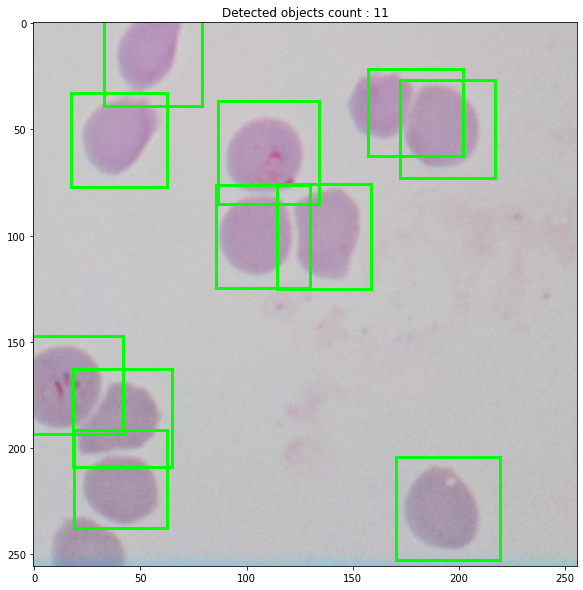

<Figure size 144x144 with 0 Axes>

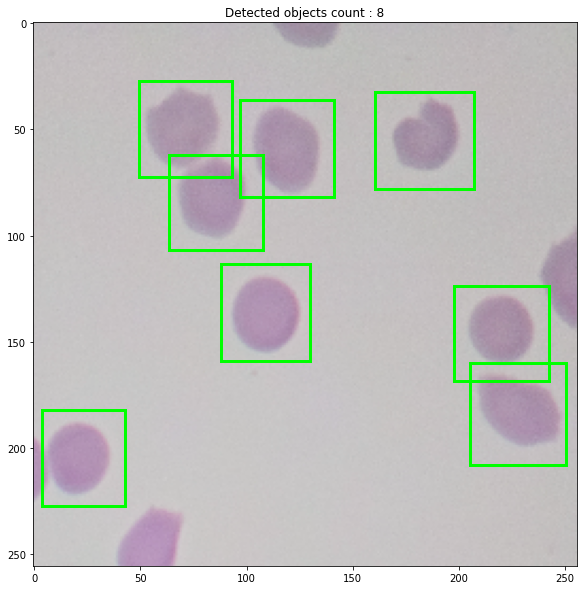

In [88]:
score_threshold  = 0.5
iou_threshold    = 0.45
for img in range(0, len(imgs_red)):
    pipeline.display_yolo(imgs_red[img], yolo_model, score_threshold, iou_threshold, plot = True)

<Figure size 144x144 with 0 Axes>

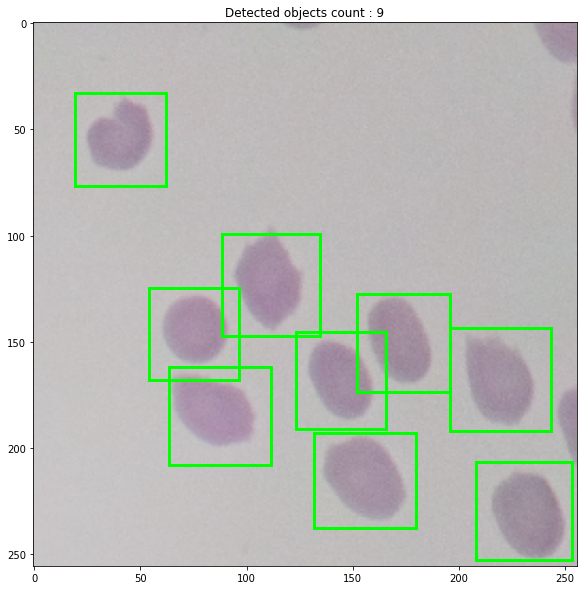

In [90]:
boxes, scores, classes = pipeline.display_yolo(imgs_red[0], yolo_model, score_threshold, iou_threshold, plot = True)

In [91]:
boxes

<tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[ 53.867573, 124.54016 ,  96.412415, 168.0411  ],
       [123.37758 , 145.16103 , 165.60301 , 191.11333 ],
       [ 18.960987,  32.750748,  62.179287,  76.47856 ],
       [131.9654  , 193.03308 , 179.68475 , 237.84906 ],
       [152.01166 , 127.49676 , 195.65366 , 173.72827 ],
       [208.1476  , 206.69083 , 253.38136 , 252.99515 ],
       [ 88.40783 ,  99.476585, 134.36127 , 147.07967 ],
       [ 63.53444 , 161.90991 , 111.49324 , 207.98392 ],
       [195.70897 , 143.6765  , 243.5673  , 191.83012 ]], dtype=float32)>

In [92]:
boxes = boxes * 5 
boxes

<tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[ 269.33786,  622.7008 ,  482.06207,  840.20557],
       [ 616.8879 ,  725.8051 ,  828.0151 ,  955.56665],
       [  94.80493,  163.75374,  310.89642,  382.39282],
       [ 659.82697,  965.1654 ,  898.42377, 1189.2454 ],
       [ 760.0583 ,  637.48376,  978.2683 ,  868.64136],
       [1040.738  , 1033.4541 , 1266.9069 , 1264.9757 ],
       [ 442.03915,  497.38293,  671.80634,  735.3983 ],
       [ 317.67218,  809.54956,  557.4662 , 1039.9196 ],
       [ 978.54486,  718.3825 , 1217.8365 ,  959.15063]], dtype=float32)>

In [93]:
#make sure all the coordinates are at least 0
cropped_img =[]
for box in boxes.numpy():
    x1 = int(round(box[0]))
    y1 = int(round(box[1]))
    x2 = int(round(box[2]))
    y2 = int(round(box[3]))
    x1 = 0 if x1 < 0 else x1
    y1 = 0 if y1 < 0 else y1
    x2 = 0 if x2 < 0 else x2
    y2 = 0 if y2 < 0 else y2
    print( x1, x2, y1, y2)
    cropped_img.append(imgs[0][ y1:y2, x1:x2])

269 482 623 840
617 828 726 956
95 311 164 382
660 898 965 1189
760 978 637 869
1041 1267 1033 1265
442 672 497 735
318 557 810 1040
979 1218 718 959


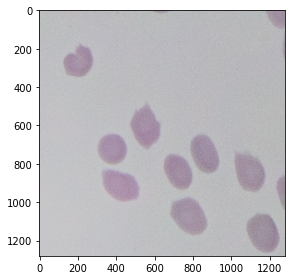

In [94]:
imshow(imgs[0])


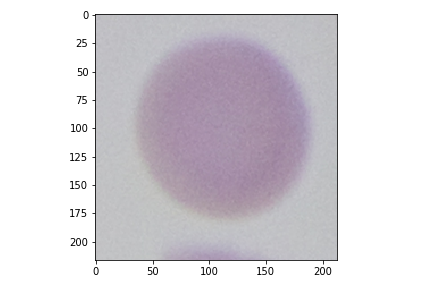
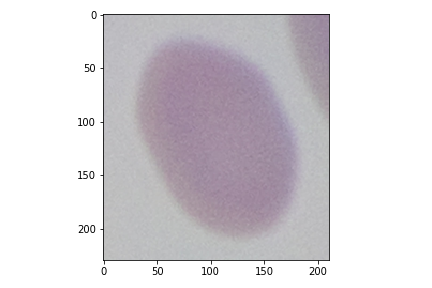
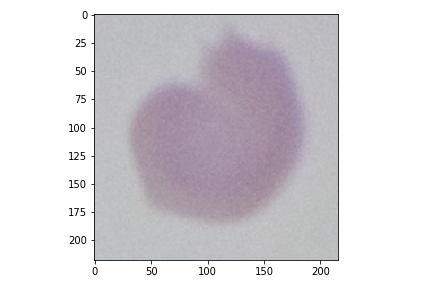
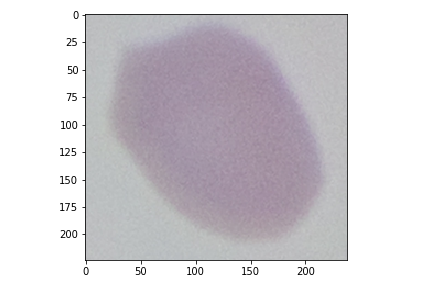
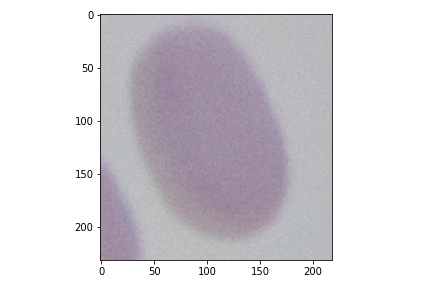
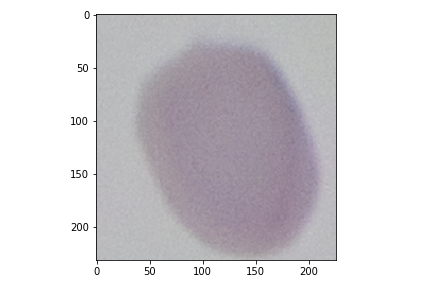
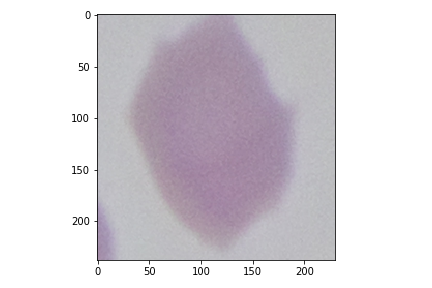
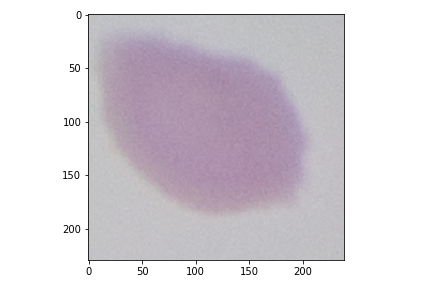
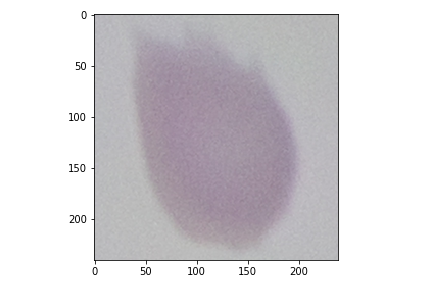

In [95]:

#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

for img in cropped_img:
    oPlot.add_plot(imshow(img)) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()

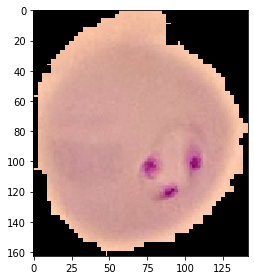

In [142]:
ref = '../data/cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png'
ref_img  = imread(ref)
imshow(ref_img)